# Try todcorr algorithm
from https://github.com/zkbt/zachopy/blob/master/oned.py

In [1]:
import matplotlib.pyplot as plt

In [51]:
import scipy
import numpy as np

def subtractContinuum(s, n=3, plot=False):
    '''Take a 1D array, use spline to subtract off continuum.
            subtractContinuum(s, n=3)
            required:
            s = the array
            optional:
            n = 3, the number of spline points to use
    '''

    x = np.arange(len(s))
    points = (np.arange(n)+1)*len(s)/(n+1)
    spline = scipy.interpolate.LSQUnivariateSpline(x,s,points)
    if plot:
        plt.ion()
        plt.figure()
        plt.plot(x, s)
        plt.plot(x, spline(x), linewidth=5, alpha=0.5)
    return s - spline(x)


def ccf(f, g, scale=1.0):
    '''Calculate the normalized cross-correlation function of two identically-size arrays.
        [required]:
        f = an N-element array (for example, spectrum of target star)
        g = an N-element array (for example, spectrum of template star)
        scale = a scalar indicating what the indices of f and g (one unit of "lag") correspond to
    '''

    # how long are our arrays
    N = len(f)

    # define the x-axis, if not supplied
    assert(len(f) == len(g))
    x = np.arange(-N+1, N, 1.0)*scale

    # calculation the normalized cross-correlation function
    sigma_f = np.sqrt(np.sum(f**2)/N)
    sigma_g = np.sqrt(np.sum(g**2)/N)
    C_fg = np.correlate(f, g, 'full')/N/sigma_f/sigma_g

    # WILL THIS WORK?
    return scipy.interpolate.interp1d(x,C_fg, fill_value=0.0, bounds_error=False)


def todcor(f, g1, g2, scale=1.0, luminosity_ratio=None):
    '''Calculate the 2D correlation of a 1D array with two template arrays.
    
    '''

    assert(len(f) == len(g1))
    assert(len(f) == len(g2))

    C_1 = ccf(f, g1, scale=scale)
    C_2 = ccf(f, g2, scale=scale)
    C_12 = ccf(g1, g2, scale=scale)

    N = len(f)
    sigma_g1 = np.sqrt(np.sum(g1**2)/N)
    sigma_g2 = np.sqrt(np.sum(g2**2)/N)

    def bestalphaprime(s1, s2):
        return sigma_g1/sigma_g2*(C_1(s1)*C_12(s2 - s1) - C_2(s2))/(C_2(s2)*C_12(s2-s1) - C_1(s1))

    def R(s1, s2):
        #a =
        if luminosity_ratio is None:
            a = np.maximum(np.minimum(bestalphaprime(s1,s2), sigma_g2/sigma_g1), 0.0)
            flexiblecorrelation = (C_1(s1) + a*C_2(s2))/np.sqrt(1.0 + 2*a*C_12(s2 - s1) + a**2)
            ok = np.isfinite(a)
            peak = np.argmax(flexiblecorrelation[ok].flatten())
            a = a[ok].flatten()[peak]
        else:
            a = luminosity_ratio*sigma_g2/sigma_g1
        # print("alpha spans", np.min(a), np.max(a))
        return (C_1(s1) + a*C_2(s2))/np.sqrt(1.0 + 2*a*C_12(s2 - s1) + a**2), a*sigma_g1/sigma_g2

    return R



In [289]:
from astropy.io import fits 
spec1 = fits.getdata("../tests/testdata/lte05200-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits") / 1e13
spec2 = fits.getdata("../tests/testdata/lte03400-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits") / 1e13
wav = fits.getdata("../tests/testdata/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits")
wav = wav/10

wav_min, wav_max = 2110, 2140

from spectrum_overload import Spectrum
spec1 = Spectrum(xaxis=wav, flux=spec1)
spec1.wav_select(wav_min-1, wav_max+1)
spec1 = spec1.normalize("quadratic") - 1
spec2 = Spectrum(xaxis=wav, flux=spec2)
spec2.wav_select(wav_min-1, wav_max+1)
spec2 = spec2.normalize("quadratic") - 1
wav = spec1.xaxis
spec1 = spec1.flux
spec2 = spec2.flux #* 0.4

shift_1 = -3.5
shift_2 = 5
from PyAstronomy import pyasl

spec1_shifted, wlprime = pyasl.dopplerShift(wav, spec1, shift_1)
spec2_shifted, wlprime = pyasl.dopplerShift(wav, spec2, shift_2)

spec_3 = spec1_shifted + spec2_shifted *0.04


spec_1 = spec1[(wav > 2110) * (wav< 2140)]
spec_2 = spec2[(wav > 2110) * (wav< 2140)]
spec_3 = spec_3[(wav > 2110) * (wav< 2140)]
wav = wav[(wav > 2110) * (wav< 2140)]
wav_3 = wav[(wav > 2110) * (wav< 2140)]
assert (len(spec_1) == len(spec_3))
# need to log resample so that evenly spaced in rv 
def log_resample(x, drv=0.01):
    # drv = v/c
    logx = np.log(x)
    logx = np.arange(logx[0], logx[-1], drv)
    return np.exp(logx)

new_full_wav = log_resample(wav, 0.5/3e5)
new_wav = log_resample(wav_3, 0.5/3e5)
new_s1 = np.interp(new_full_wav, wav, spec_1)
new_s2 = np.interp(new_full_wav, wav, spec_2)
new_s3 = np.interp(new_wav, wav_3, spec_3)


# RV step size
wav_diff = np.diff(new_full_wav)
v = wav_diff/new_full_wav[:-1] *3e5
print("RV step size", v, "km/s")

RV step size [0.50000042 0.50000042 0.50000042 ... 0.50000042 0.50000042 0.50000042] km/s


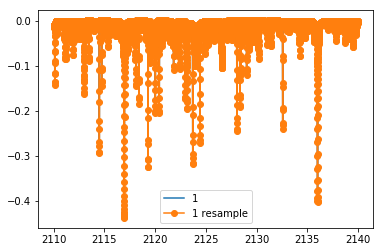

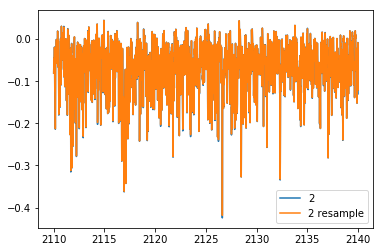

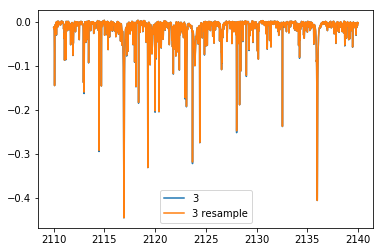

In [290]:
plt.plot(wav, spec_1, label="1")
plt.plot(new_full_wav, new_s1, "o-", label="1 resample")
plt.legend()
plt.show()
plt.plot(wav, spec_2, label="2")
plt.plot(new_full_wav, new_s2, label="2 resample")
plt.legend()
plt.show()
plt.plot(wav_3, spec_3, label="3")
plt.plot(new_wav, new_s3, label="3 resample")
plt.legend()
plt.show()

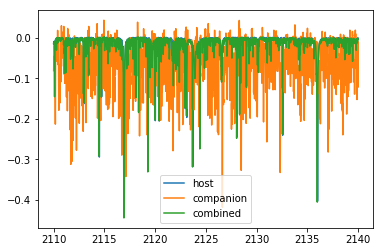

In [291]:
# s1 = subtractContinuum(new_s1, n=5)
# s2 = subtractContinuum(new_s2, n=5)
# s3 = subtractContinuum(new_s3, n=5)
s1 = new_s1
s2 = new_s2
s3 = new_s3

plt.plot(new_full_wav, s1, label="host")
plt.plot(new_full_wav, s2, label="companion")
plt.plot(new_wav, s3, label="combined")
plt.legend()
plt.show()

max lag =  4234.5 km/s
8469


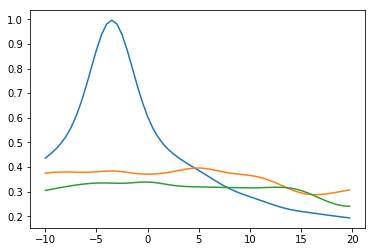

In [292]:
# Individual ccfs
print("max lag = ", 0.5*len(s1), "km/s")
ccf_1 = ccf(s3, s1, scale=0.5)
ccf_2 = ccf(s3, s2, scale=0.5)
ccf_12 = ccf(s1, s2, scale=0.5)

print(len(s2))

import matplotlib.pyplot as plt
N = len(s1)
scale = 1
k = np.arange(-10, 20, 0.25)
plt.plot(k, ccf_1(k))
plt.plot(k, ccf_2(k))
plt.plot(k, ccf_12(k))
#plt.xlabel("rv")

In [293]:
# Scale is the RV between each step.
# I resample in log space with steps of 0.5/3e5 so that the scale becomes 0.5 km/s
 
R = todcor(s3, s2, s1, scale=0.5)

In [294]:
rv = np.arange(-15, 15, .25)
gamma = np.arange(-15, 15, .25)
RV, GAM = np.meshgrid(rv, gamma, indexing="ij")
c_n1_n2 = np.empty((len(rv), len(gamma)))
a_n1_n2 = np.empty((len(rv), len(gamma)))

for jj, y in enumerate(gamma):
    for ii, x in enumerate(rv):

        res = R(x, y) 
        c_n1_n2[ii, jj] = res[0]
        a_n1_n2[ii, jj] = res[1]



In [295]:
idx = np.argmax(c_n1_n2)
rv_val = RV.flatten()[idx]
gamma_val = GAM.flatten()[idx]

print("shift_1 =", shift_1,"km/s")
print("Maximum at gamma =", gamma_val,"km/s")
print("shift_2 =", shift_2,"km/s")
print("Maximum at rv =", rv_val,"km/s")


shift_1 = -3.5 km/s
Maximum at gamma = -3.5 km/s
shift_2 = 5 km/s
Maximum at rv = 5.0 km/s


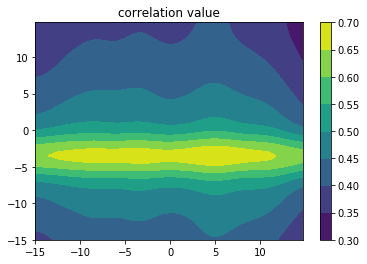

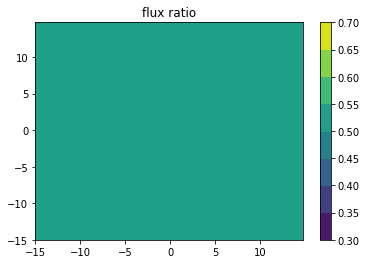

In [296]:
fig=plt.figure()
ax1 = fig.add_subplot(111)
cx1 = ax1.contourf(RV, GAM, c_n1_n2)
plt.colorbar(cx1)
plt.title("correlation value")
plt.show()

a_n1_n2
cx2 = plt.contourf(RV, GAM, a_n1_n2)
plt.colorbar(cx1)
plt.title("flux ratio")
plt.show()